In [21]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from pathlib import Path
from tqdm import tqdm
from datasets_utils import FilteredFlowersDataset

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

VIS_DIR = Path('visualizations')
VIS_DIR.mkdir(exist_ok=True)
print(f"Saving visualizations to: {VIS_DIR.resolve()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Saving visualizations to: C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\visualizations
Using device: cuda


In [ ]:
runs_dir = Path('./runs')
runs = sorted([d for d in runs_dir.iterdir() if d.is_dir()], key=lambda d: d.stat().st_mtime)
if not runs:
    raise RuntimeError("No runs found. Please run the training notebooks first.")

latest_run = runs[-1]
print(f"Analyzing run directory: {latest_run.resolve()}")

transfer_path = latest_run / 'best_model.pth'
scratch_path = latest_run / 'scratch_model.pth'

if not transfer_path.exists():
    raise FileNotFoundError(f"Could not find {transfer_path}")
if not scratch_path.exists():
    raise FileNotFoundError(f"Could not find {scratch_path}")

print("Found both model checkpoints.")

Analyzing run directory: C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251207-151426
Found both model checkpoints.


In [ ]:
# Load Configuration and Data
# We load the config from the final transfer model checkpoint (which contains metadata)
# best_model.pth only contain weights, so we use transfer_learning_model.pth for config
config_path = latest_run / 'transfer_learning_model.pth'
if not config_path.exists():
     raise FileNotFoundError(f"Could not find {config_path} to load configuration")

checkpoint_config = torch.load(config_path, map_location=device)
CONFIG = checkpoint_config['config']
class_names = checkpoint_config.get('class_names', [f'Class {i}' for i in range(CONFIG['num_classes'])])

print(f"Configuration loaded. Num classes: {CONFIG['num_classes']}")

# Define Transforms (Validation/Test standard)
data_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Reconstruct Test Dataset
# We must use the exact same logic as the training notebooks to get the same test split
print("Loading dataset...")
train_split = datasets.Flowers102(root='./data', split='train', download=True, transform=None)
val_split = datasets.Flowers102(root='./data', split='val', download=True, transform=None)
test_split = datasets.Flowers102(root='./data', split='test', download=True, transform=None)
base_dataset = torch.utils.data.ConcatDataset([train_split, val_split, test_split])

# Filter classes
available_class_count = 102
max_classes = min(CONFIG.get('max_classes', 20), available_class_count)
selected_class_ids = list(range(max_classes))
class_mapping = {original: new_idx for new_idx, original in enumerate(selected_class_ids)}

# Get indices
temp_dataset = FilteredFlowersDataset(base_dataset, selected_class_ids, label_map=class_mapping)
selected_indices = temp_dataset.indices

# Shuffle with same seed
rng = np.random.default_rng(42)
rng.shuffle(selected_indices)

# Split
total_len = len(selected_indices)
train_size = int(CONFIG['train_split'] * total_len)
val_size = int(CONFIG['val_split'] * total_len)
test_size = total_len - train_size - val_size

test_indices = selected_indices[train_size+val_size:]

# Create Test Dataset and Loader
test_dataset = FilteredFlowersDataset(
    base_dataset, 
    selected_class_ids, 
    label_map=class_mapping, 
    indices=test_indices, 
    transform=data_transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Test Dataset Size: {len(test_dataset)} images")

Configuration loaded. Num classes: 20
Loading dataset...
FilteredFlowersDataset: Found 8189 total labels in base_dataset
FilteredFlowersDataset: Selected 1155 images for 20 classes
Test Dataset Size: 116 images
FilteredFlowersDataset: Found 8189 total labels in base_dataset
FilteredFlowersDataset: Selected 1155 images for 20 classes
Test Dataset Size: 116 images


In [ ]:
def load_resnet_model(path, device, num_classes):
    checkpoint = torch.load(path, map_location=device)
    
    model = models.resnet50(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model = model.to(device)
    model.eval()
    return model

print("Loading models into memory...")
model_transfer = load_resnet_model(transfer_path, device, CONFIG['num_classes'])
model_scratch = load_resnet_model(scratch_path, device, CONFIG['num_classes'])
print("Models loaded successfully.")

Loading models into memory...
Models loaded successfully.
Models loaded successfully.


In [ ]:
# Run Inference
def get_predictions(model, loader):
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Inference"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("Evaluating Transfer Learning Model...")
preds_transfer, labels_transfer, probs_transfer = get_predictions(model_transfer, test_loader)

print("Evaluating From-Scratch Model...")
preds_scratch, labels_scratch, probs_scratch = get_predictions(model_scratch, test_loader)

acc_transfer = accuracy_score(labels_transfer, preds_transfer)
acc_scratch = accuracy_score(labels_scratch, preds_scratch)

print(f"\nTransfer Learning Accuracy: {acc_transfer:.2%}")
print(f"From Scratch Accuracy:      {acc_scratch:.2%}")

Evaluating Transfer Learning Model...


Inference: 100%|██████████| 4/4 [00:13<00:00,  3.37s/it]


Evaluating From-Scratch Model...


Inference: 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


Transfer Learning Accuracy: 98.28%
From Scratch Accuracy:      82.76%


## Visualization 1: Confusion Matrices
Comparing where each model makes mistakes.

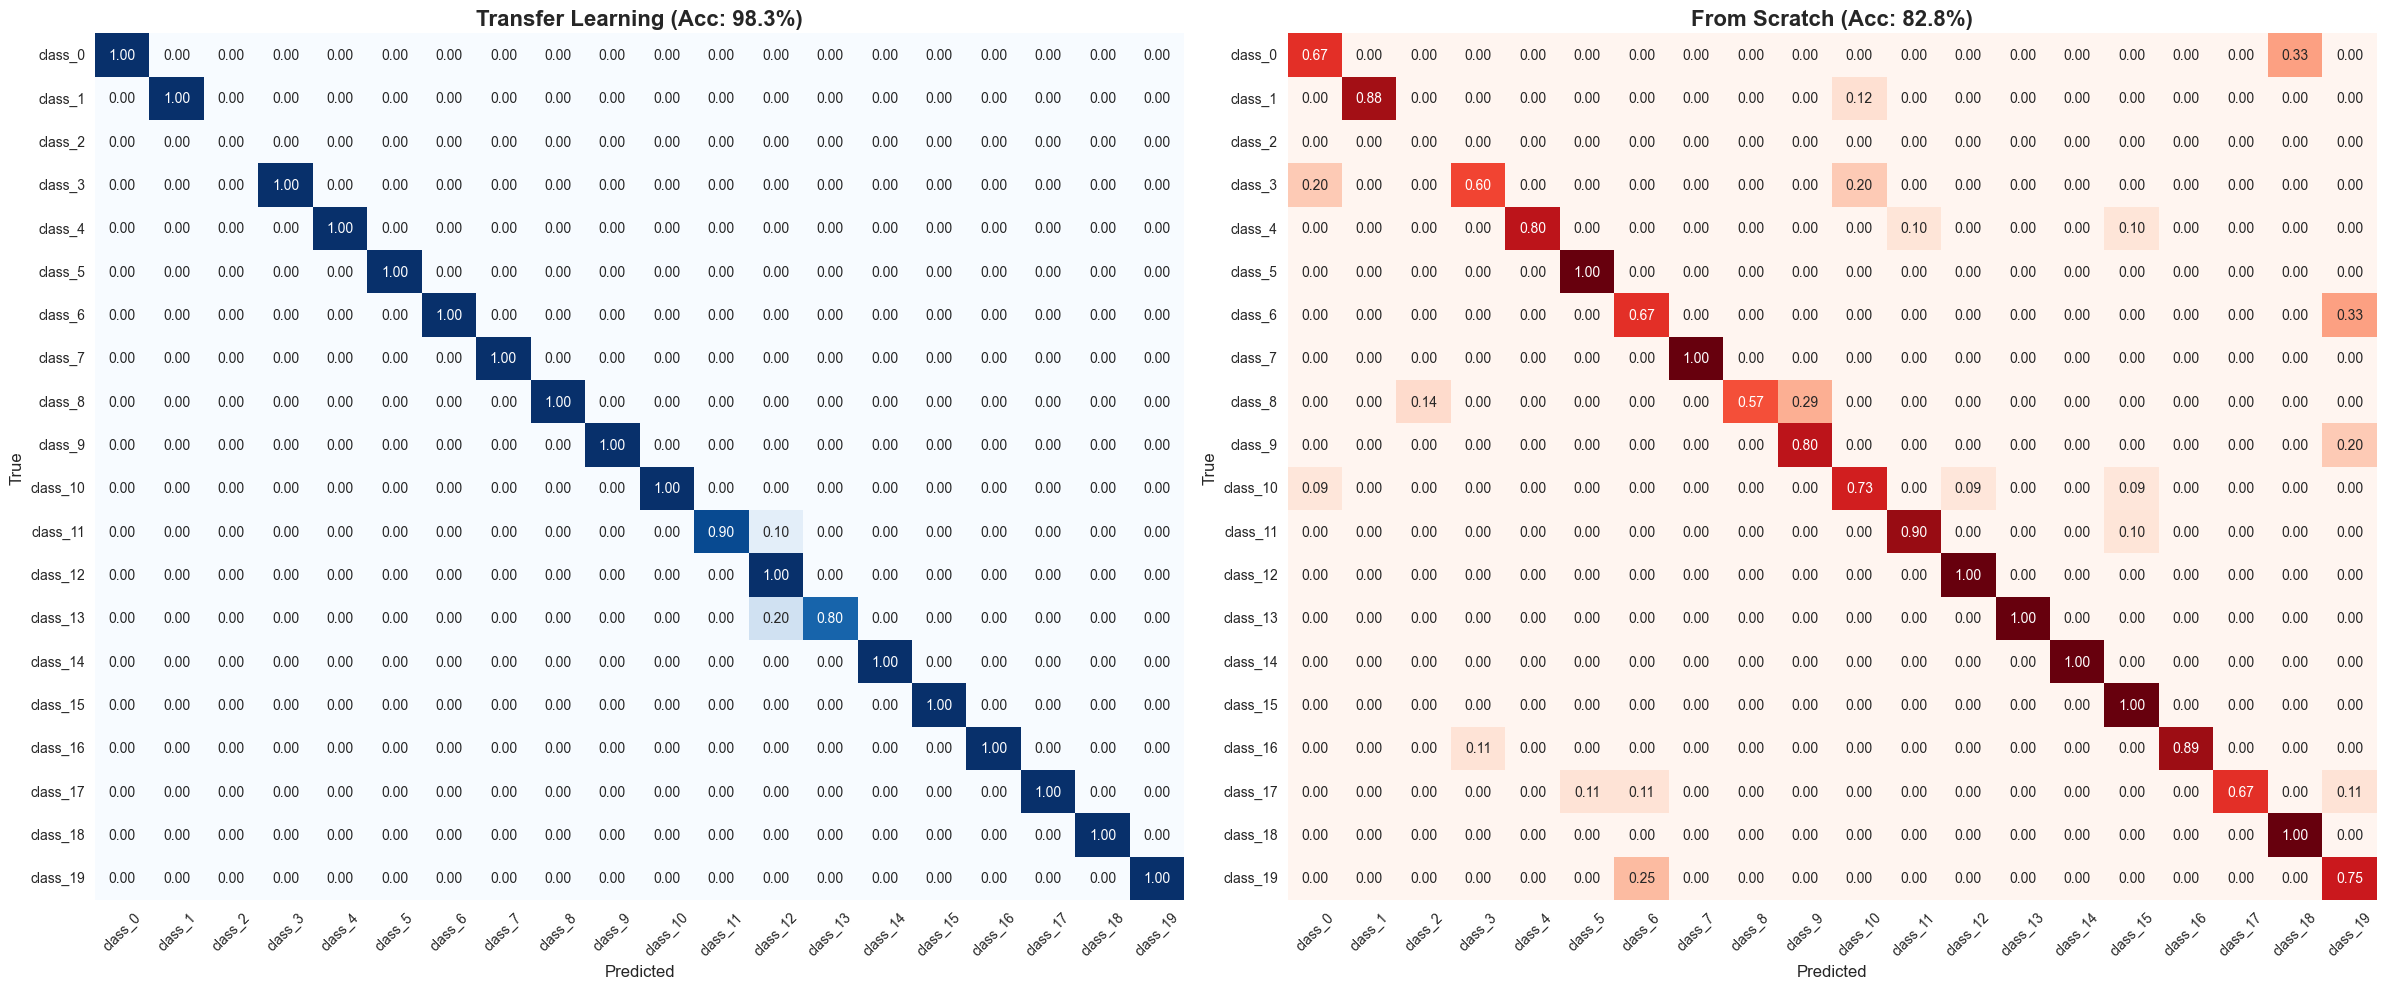

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Transfer Learning CM
cm_transfer = confusion_matrix(labels_transfer, preds_transfer, labels=range(len(class_names)), normalize='true')
sns.heatmap(cm_transfer, ax=axes[0], annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
axes[0].set_title(f'Transfer Learning (Acc: {acc_transfer:.1%})', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# From Scratch CM
cm_scratch = confusion_matrix(labels_scratch, preds_scratch, labels=range(len(class_names)), normalize='true')
sns.heatmap(cm_scratch, ax=axes[1], annot=True, fmt='.2f', cmap='Reds', 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
axes[1].set_title(f'From Scratch (Acc: {acc_scratch:.1%})', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(VIS_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 2: Per-Class Accuracy Comparison
Which classes are difficult for both models? Which ones does Transfer Learning solve better?

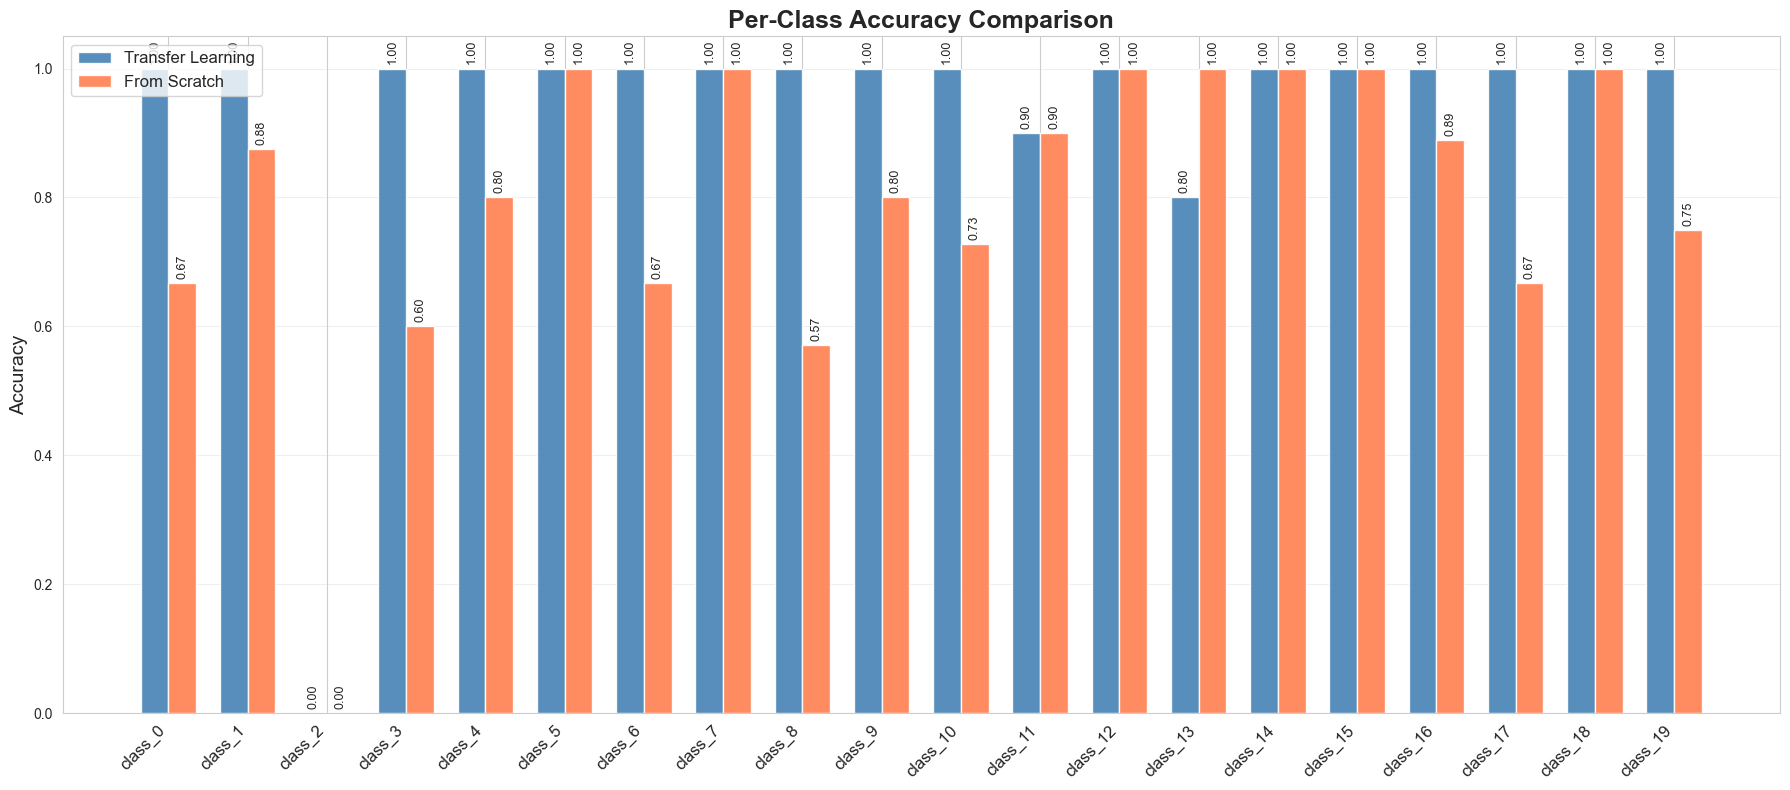

In [ ]:
class_acc_transfer = cm_transfer.diagonal()
class_acc_scratch = cm_scratch.diagonal()

x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(x - width/2, class_acc_transfer, width, label='Transfer Learning', color='steelblue', alpha=0.9)
rects2 = ax.bar(x + width/2, class_acc_scratch, width, label='From Scratch', color='coral', alpha=0.9)

ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Per-Class Accuracy Comparison', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.05)

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90, fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig(VIS_DIR / 'per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 3: Confidence Analysis
Are the models confident when they are wrong? (Calibration check)

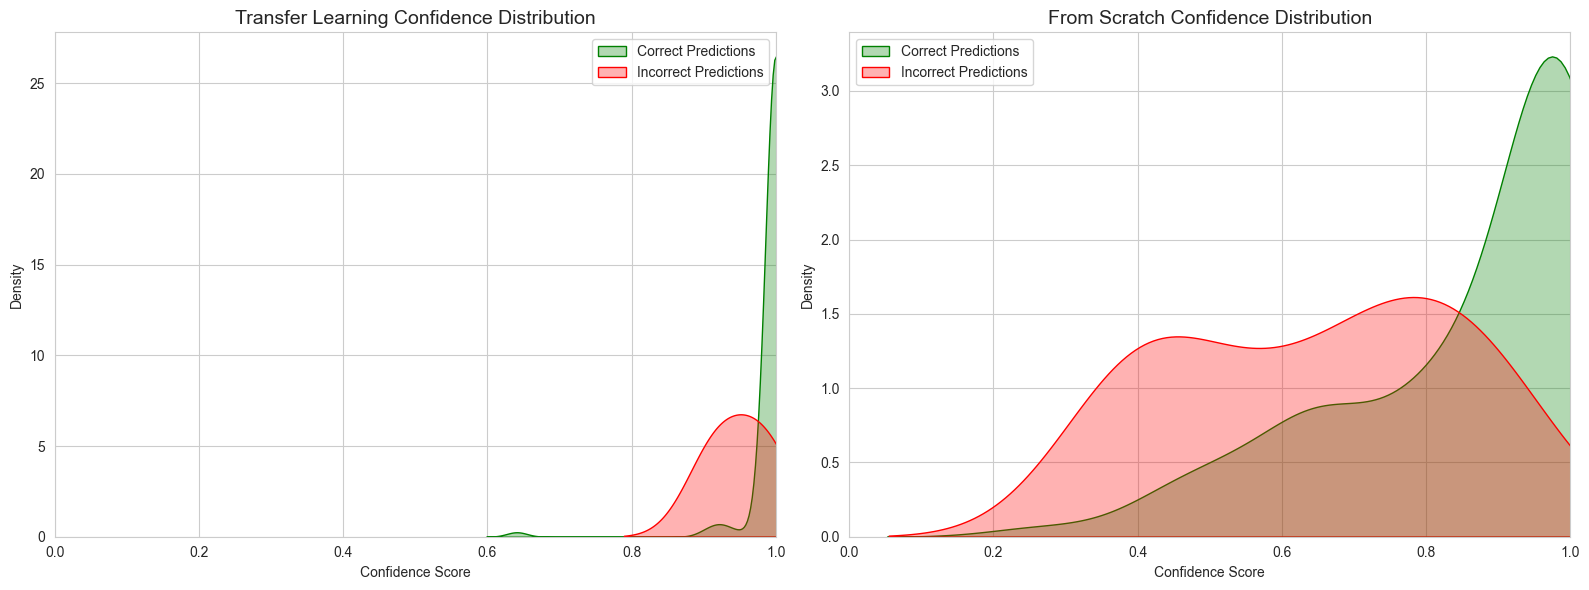

In [ ]:
# Get confidence of the predicted class
conf_transfer = np.max(probs_transfer, axis=1)
conf_scratch = np.max(probs_scratch, axis=1)

# Split by correct/incorrect
correct_mask_t = preds_transfer == labels_transfer
correct_mask_s = preds_scratch == labels_scratch

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Transfer
sns.kdeplot(conf_transfer[correct_mask_t], ax=axes[0], label='Correct Predictions', fill=True, color='green', alpha=0.3)
if np.any(~correct_mask_t):
    sns.kdeplot(conf_transfer[~correct_mask_t], ax=axes[0], label='Incorrect Predictions', fill=True, color='red', alpha=0.3)
axes[0].set_title('Transfer Learning Confidence Distribution', fontsize=14)
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_xlim(0, 1)

# Scratch
sns.kdeplot(conf_scratch[correct_mask_s], ax=axes[1], label='Correct Predictions', fill=True, color='green', alpha=0.3)
if np.any(~correct_mask_s):
    sns.kdeplot(conf_scratch[~correct_mask_s], ax=axes[1], label='Incorrect Predictions', fill=True, color='red', alpha=0.3)
axes[1].set_title('From Scratch Confidence Distribution', fontsize=14)
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.savefig(VIS_DIR / 'confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 4: The Transfer Learning Advantage
Images where Transfer Learning got it right but From Scratch got it wrong.

Found 19 samples where Transfer Learning outperformed Scratch.
Showing 5 random examples:


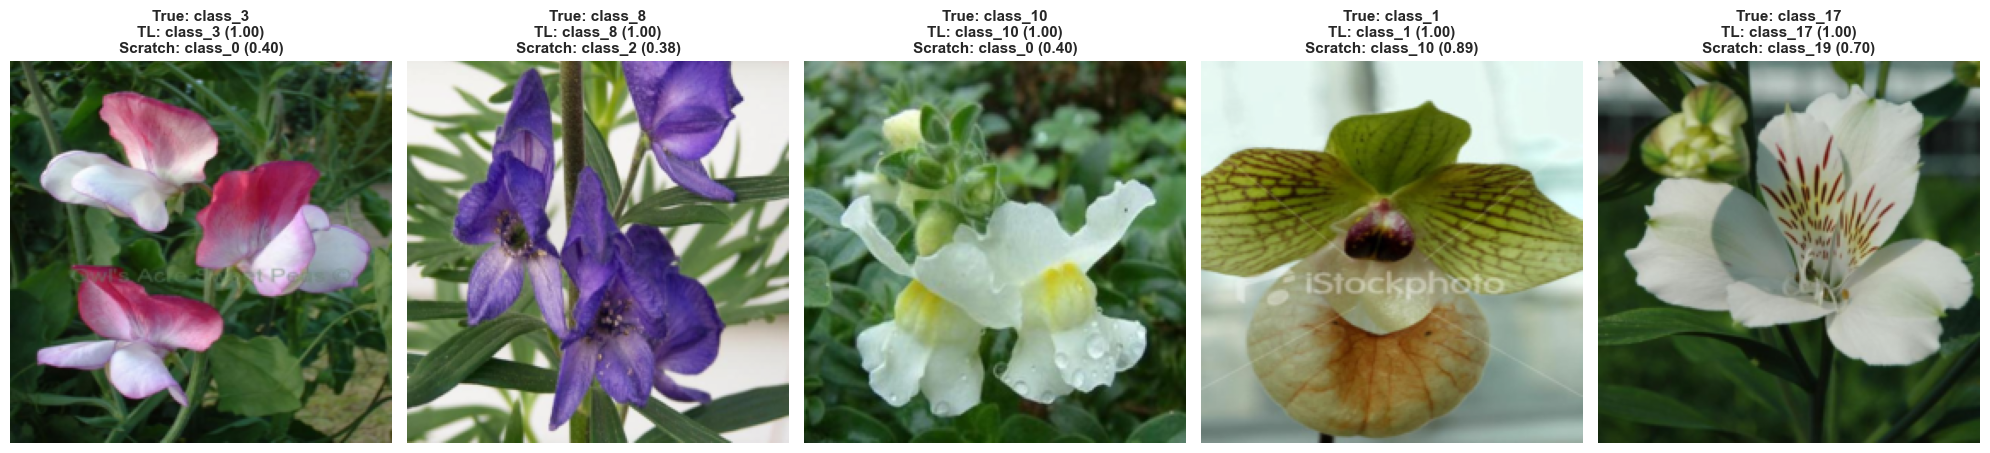

In [ ]:
def imshow(img, ax, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.axis('off')

# Find indices where Transfer is Correct AND Scratch is Wrong
advantage_indices = np.where(correct_mask_t & ~correct_mask_s)[0]

if len(advantage_indices) > 0:
    num_samples = min(5, len(advantage_indices))
    selected_indices = np.random.choice(advantage_indices, num_samples, replace=False)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    if num_samples == 1: axes = [axes]
    
    print(f"Found {len(advantage_indices)} samples where Transfer Learning outperformed Scratch.")
    print(f"Showing {num_samples} random examples:")
    
    for i, idx in enumerate(selected_indices):
        img, label = test_dataset[idx]
        t_pred = class_names[preds_transfer[idx]]
        s_pred = class_names[preds_scratch[idx]]
        true_label = class_names[label]
        
        # Get confidence for the predictions
        t_conf = probs_transfer[idx][preds_transfer[idx]]
        s_conf = probs_scratch[idx][preds_scratch[idx]]
        
        title = f"True: {true_label}\nTL: {t_pred} ({t_conf:.2f})\nScratch: {s_pred} ({s_conf:.2f})"
        imshow(img, axes[i], title)
        
    plt.tight_layout()
    plt.savefig(VIS_DIR / 'transfer_advantage_gallery.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("The From Scratch model didn't make any unique mistakes compared to Transfer Learning in this batch.")

## Visualization 5: Hardest Samples
Images where both models failed.

Found 1 samples where BOTH models failed.


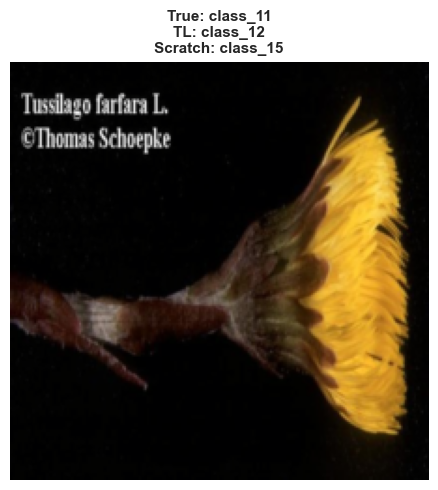

In [ ]:
both_wrong_indices = np.where(~correct_mask_t & ~correct_mask_s)[0]

if len(both_wrong_indices) > 0:
    num_samples = min(5, len(both_wrong_indices))
    selected_indices = np.random.choice(both_wrong_indices, num_samples, replace=False)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    if num_samples == 1: axes = [axes]
    
    print(f"Found {len(both_wrong_indices)} samples where BOTH models failed.")
    
    for i, idx in enumerate(selected_indices):
        img, label = test_dataset[idx]
        t_pred = class_names[preds_transfer[idx]]
        s_pred = class_names[preds_scratch[idx]]
        true_label = class_names[label]
        
        title = f"True: {true_label}\nTL: {t_pred}\nScratch: {s_pred}"
        imshow(img, axes[i], title)
        
    plt.tight_layout()
    plt.savefig(VIS_DIR / 'hardest_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No samples found where both models failed.")

## Visualization 6: Metrics Comparison
Comparing Accuracy, Precision, Recall, and F1-Score to get a holistic view of performance.

Metrics Comparison:
------------------------------------------------------------
   Metric  Transfer Learning  From Scratch
 Accuracy             0.9828        0.8276
Precision             0.9885        0.8757
   Recall             0.9828        0.8276
 F1-Score             0.9838        0.8381
------------------------------------------------------------


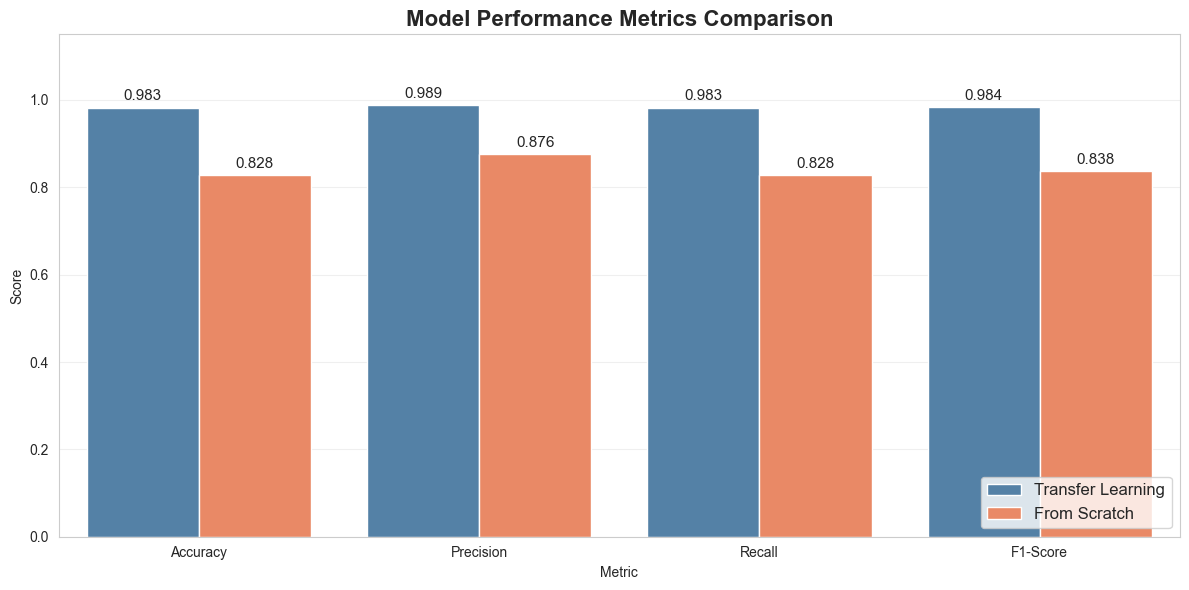

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Calculate weighted metrics
# We use 'weighted' average to account for class imbalance if any
t_precision, t_recall, t_f1, _ = precision_recall_fscore_support(
    labels_transfer, preds_transfer, 
    average='weighted', 
    labels=range(len(class_names)),
    zero_division=0
)

s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(
    labels_scratch, preds_scratch, 
    average='weighted', 
    labels=range(len(class_names)),
    zero_division=0
)

# Compile metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Transfer Learning': [acc_transfer, t_precision, t_recall, t_f1],
    'From Scratch': [acc_scratch, s_precision, s_recall, s_f1]
}

df_metrics = pd.DataFrame(metrics_data)

# Display Table
print("Metrics Comparison:")
print("-" * 60)
print(df_metrics.round(4).to_string(index=False))
print("-" * 60)

# Plot
plt.figure(figsize=(12, 6))
df_melted = df_metrics.melt(id_vars="Metric", var_name="Model", value_name="Score")
ax = sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette=['steelblue', 'coral'])

plt.title("Model Performance Metrics Comparison", fontsize=16, fontweight='bold')
plt.ylim(0, 1.15) # Extra space for labels
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=12, loc='lower right')

# Add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=11)

plt.tight_layout()
plt.savefig(VIS_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 7: Latent Space Visualization (t-SNE)
We extract the high-dimensional feature vectors (2048 dimensions) from the ResNet backbone (before the final classification head) and project them into 2D space using t-SNE.

*   Well-separated clusters indicate that the model has learned strong, discriminative features.
*   Overlapping points indicate confusion or lack of feature separation.

Extracting features from Transfer Learning model...


Extracting Features: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]



Extracting features from Scratch model...


Extracting Features: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]



Feature shape: (116, 2048)
Computing t-SNE projections (this may take a moment)...


C:\Users\mar20\AppData\Local\Temp\ipykernel_4100\4193833225.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(class_names))


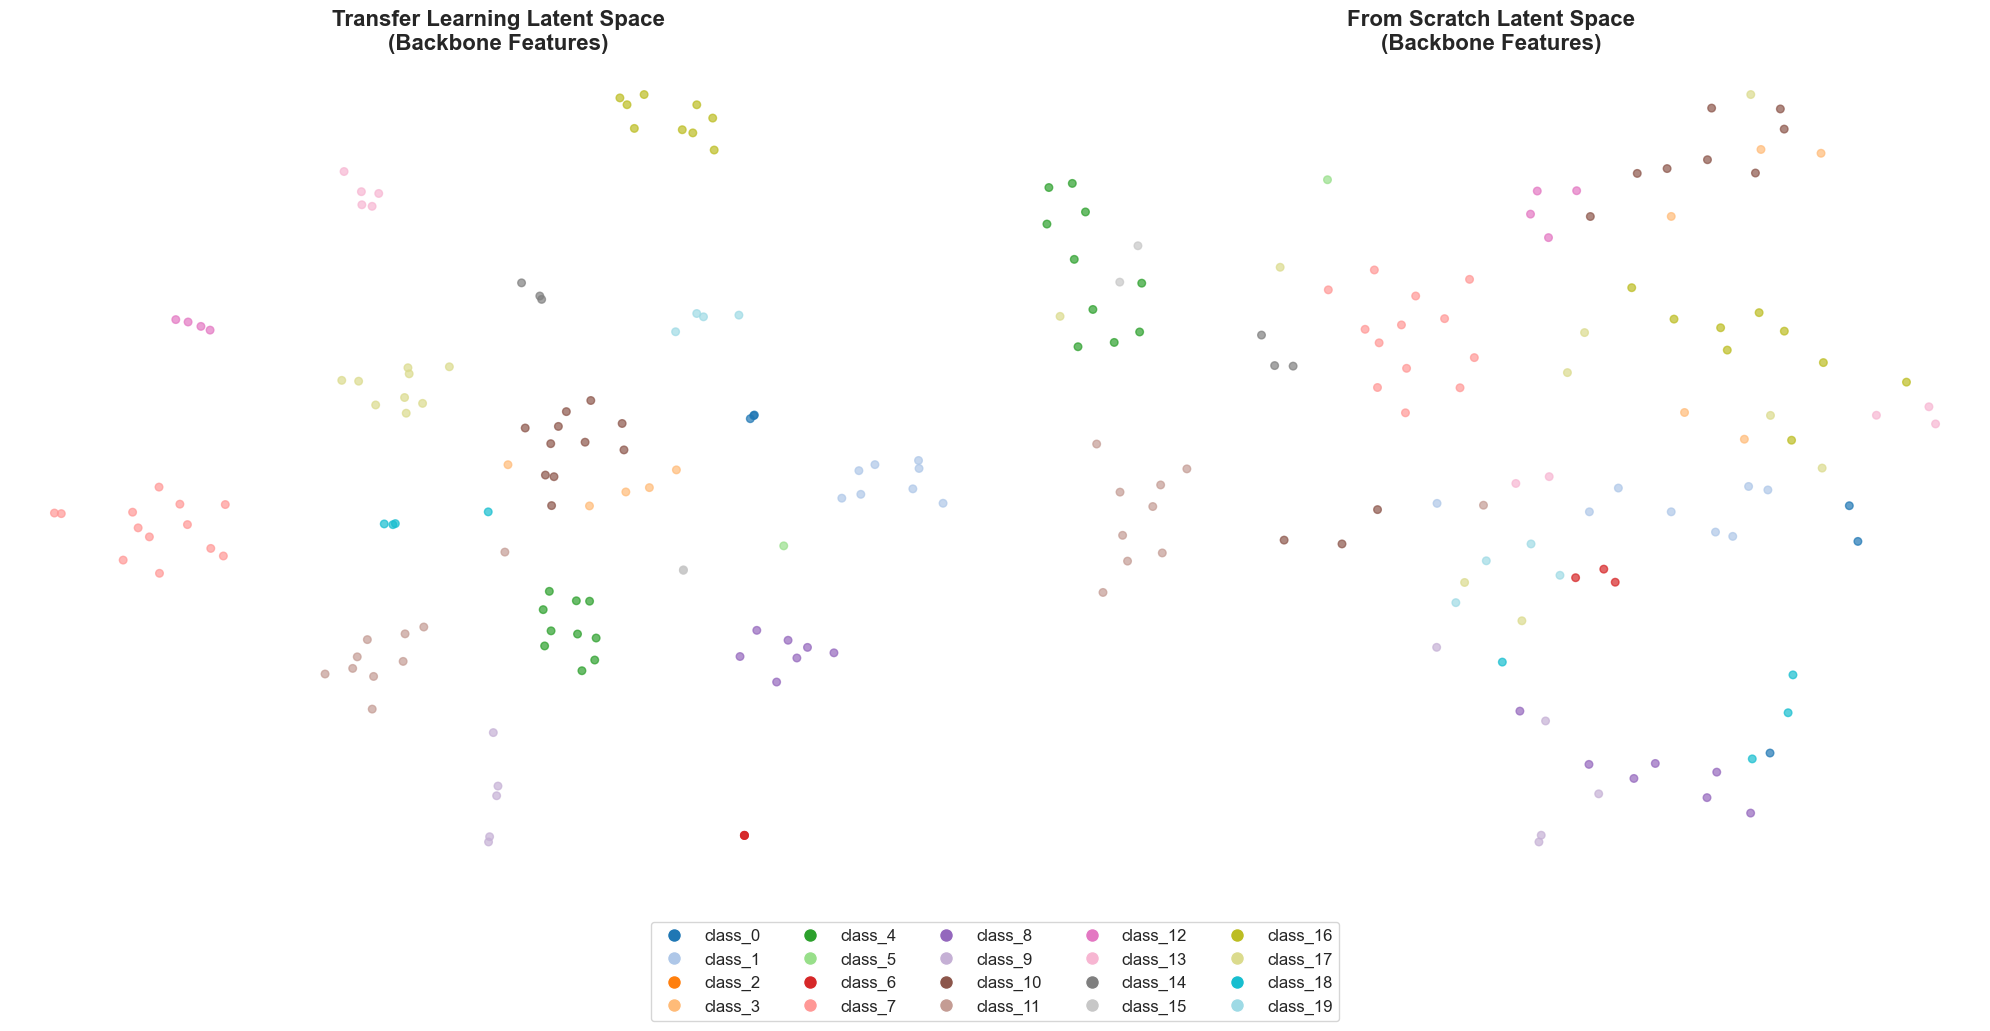

In [ ]:
from sklearn.manifold import TSNE

def get_latent_features(model, loader, device):
    """Extract features from the penultimate layer (before the classifier)."""
    model.eval()
    features = []
    labels_list = []
    
    # Store original fc layer to restore later
    original_fc = model.fc
    # Replace with Identity to get the backbone output (2048-dim for ResNet50)
    model.fc = nn.Identity()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting Features"):
            images = images.to(device)
            # Forward pass now stops after avgpool+flatten
            feats = model(images)
            features.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
            
    # Restore original model structure
    model.fc = original_fc
    
    return np.concatenate(features), np.concatenate(labels_list)

print("Extracting features from Transfer Learning model...")
feats_transfer, labels_t = get_latent_features(model_transfer, test_loader, device)

print("Extracting features from Scratch model...")
feats_scratch, labels_s = get_latent_features(model_scratch, test_loader, device)

print(f"Feature shape: {feats_transfer.shape}")

# Compute t-SNE
print("Computing t-SNE projections")
# Using default n_iter (1000) and learning_rate to ensure compatibility
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')

# We compute t-SNE separately to see the intrinsic structure of each space
tsne_transfer = tsne.fit_transform(feats_transfer)
tsne_scratch = tsne.fit_transform(feats_scratch)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Define a colormap that can handle our number of classes
cmap = plt.cm.get_cmap('tab20', len(class_names))

def plot_embedding(ax, X, y, title):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.7, s=30)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    return scatter

scatter1 = plot_embedding(axes[0], tsne_transfer, labels_t, "Transfer Learning Latent Space\n(Backbone Features)")
scatter2 = plot_embedding(axes[1], tsne_scratch, labels_s, "From Scratch Latent Space\n(Backbone Features)")

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), label=name, markersize=10) 
           for i, name in enumerate(class_names)]

fig.legend(handles=handles, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.15), fontsize=12)

plt.tight_layout()
plt.savefig(VIS_DIR / 'latent_space_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 8: Misclassification Analysis (Input vs. Predicted Class)
To better understand *why* the model made a mistake, we display:
1.  The **Input Image** (which was misclassified).
2.  A **Representative Image** of the class that the model *predicted*.

This helps us see if the mistake was reasonable (e.g., the input looks very similar to the predicted class) or completely off.

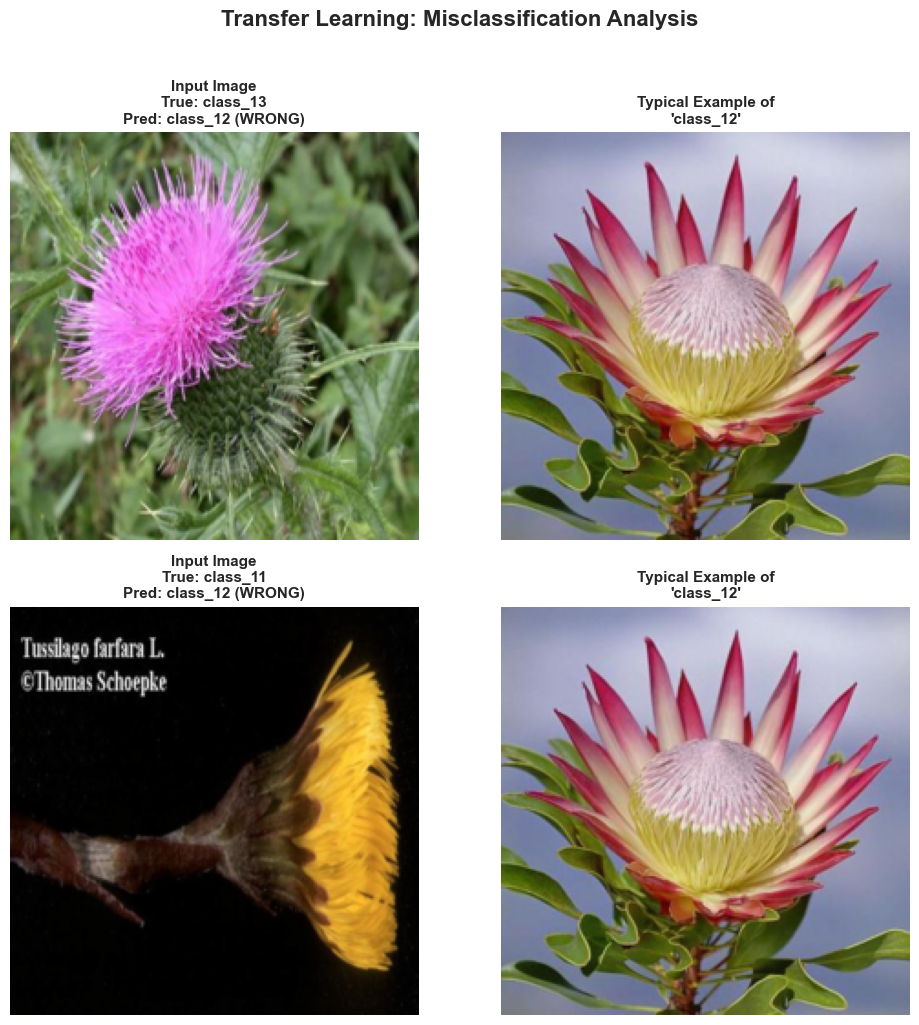

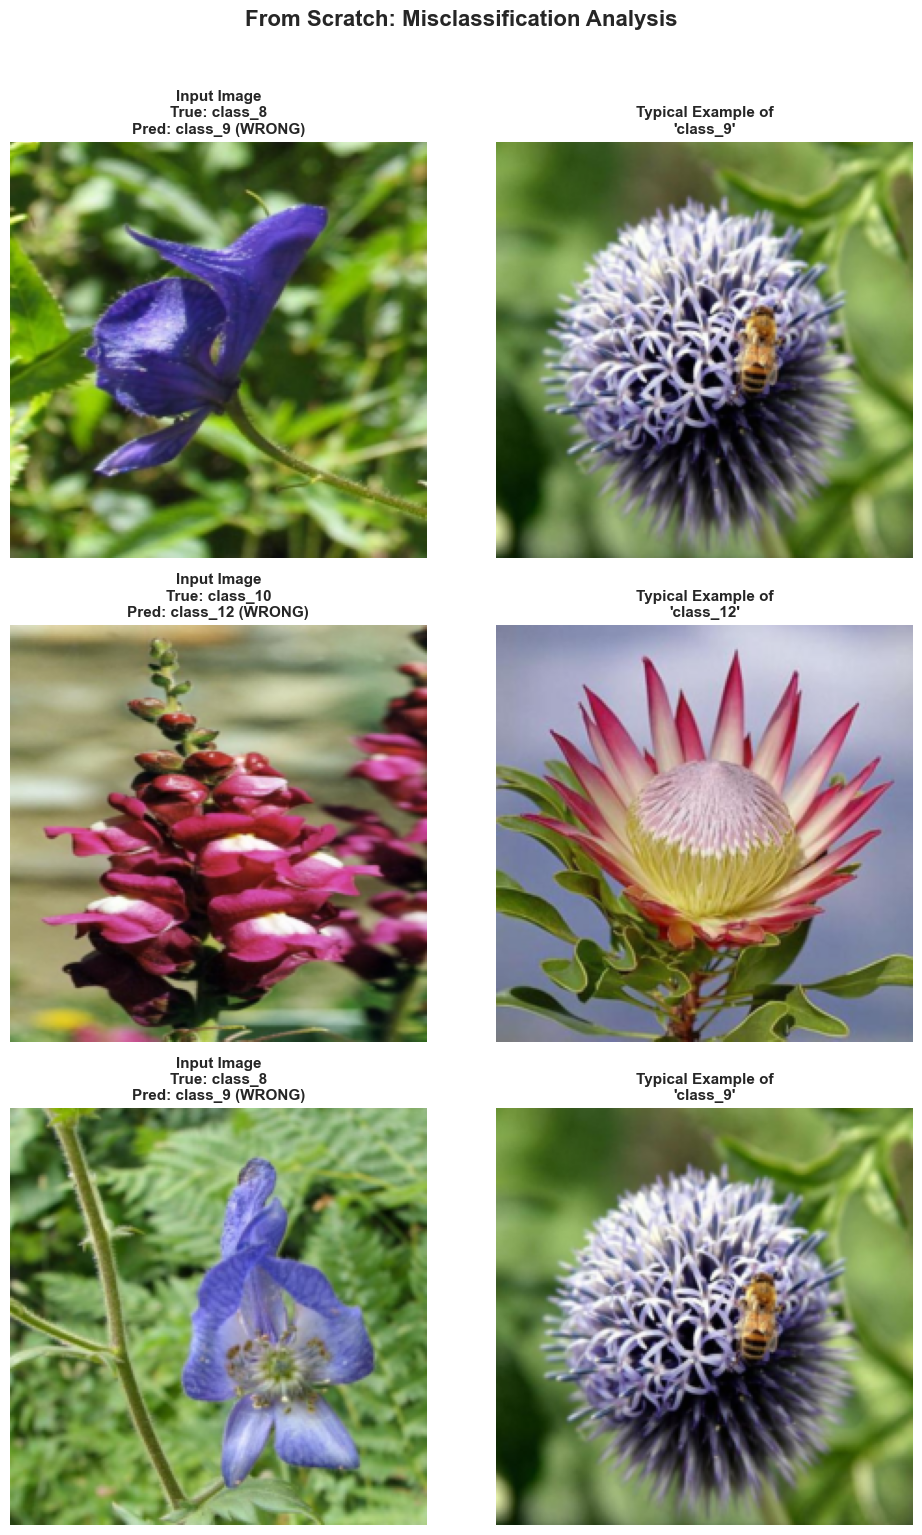

In [22]:
def find_example_image(class_idx, dataset):
    """Finds the first image in the dataset that belongs to the specified class."""
    # We iterate through the dataset to find a match. 
    # In a production setting, you might want to pre-index this.
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label == class_idx:
            return dataset[i][0]
    return None

def visualize_misclassification_analysis(model_name, preds, labels, dataset, class_names, num_samples=3):
    misclassified_idxs = np.where(preds != labels)[0]
    
    if len(misclassified_idxs) == 0:
        print(f"No misclassifications found for {model_name}.")
        return

    # Select random samples
    selected_idxs = np.random.choice(misclassified_idxs, min(num_samples, len(misclassified_idxs)), replace=False)
    
    fig, axes = plt.subplots(len(selected_idxs), 2, figsize=(10, 5 * len(selected_idxs)))
    if len(selected_idxs) == 1: axes = axes.reshape(1, -1)
    
    fig.suptitle(f"{model_name}: Misclassification Analysis", fontsize=16, y=1.02, fontweight='bold')
    
    for i, idx in enumerate(selected_idxs):
        # 1. The Input Image (Misclassified)
        input_img, true_label = dataset[idx]
        pred_label = preds[idx]
        
        # 2. An Example of the Predicted Class
        # We search the dataset for an image that ACTUALLY belongs to the predicted class
        pred_class_example = find_example_image(pred_label, dataset)
        
        # Plot Input
        true_name = class_names[true_label]
        pred_name = class_names[pred_label]
        
        imshow(input_img, axes[i, 0], f"Input Image\nTrue: {true_name}\nPred: {pred_name} (WRONG)")
        
        # Plot Example
        if pred_class_example is not None:
            imshow(pred_class_example, axes[i, 1], f"Typical Example of\n'{pred_name}'")
        else:
            axes[i, 1].text(0.5, 0.5, "No example found\nin test set", ha='center')
            axes[i, 1].axis('off')
            
    plt.tight_layout()
    plt.savefig(VIS_DIR / f'misclass_analysis_{model_name.replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

# Run for Transfer Learning
visualize_misclassification_analysis("Transfer Learning", preds_transfer, labels_transfer, test_dataset, class_names)

# Run for From Scratch
visualize_misclassification_analysis("From Scratch", preds_scratch, labels_scratch, test_dataset, class_names)